<a href="https://colab.research.google.com/github/Jass1313c/comp215/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime, json, requests
from pprint import pprint

param = { "format": "geojson", "starttime": "2024-03-10","limit": 20000, "endtime": "2024-05-30"}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

pprint(data)

for feature in data['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    Latitude = feature['geometry']['coordinates'][1]
    Longitude = feature['geometry']['coordinates'][0]
    print(f"Mag: {feature['properties']['mag']},   Place: {feature['properties']['place']},   Time: {datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)},   Lat: {Latitude},   Long: {Longitude}")

In [3]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import datetime, json, requests
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from dataclasses import dataclass
import plotly.graph_objects as go
from pprint import pprint
import networkx as nx
import pandas as pd
import pyproj


In [ ]:
@dataclass
class Earthquake:
  Mag: float
  Place: str
  Time: datetime.datetime
  Lat: float
  Long: float
  Depth: float

param = { "format": "geojson", "starttime": "2024-03-14","limit": 20000, "endtime": "2024-06-15", "minmagnitude": 1}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

def __init__(self, Mag, Place, Time, Lat, Long, Depth):
    self.Mag = Mag
    self.Place = Place
    self.Time = Time
    self.Lat = Lat
    self.Long = Long
    self.Depth = Depth

earthquake_data = [
    Earthquake(
        Mag=feature['properties']['mag'],
        Place=feature['properties']['place'],
        Time=datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000),
        Lat=feature['geometry']['coordinates'][1],
        Long=feature['geometry']['coordinates'][0],
        Depth=feature['geometry']['coordinates'][2]
    )
    for feature in data['features']
    if feature['geometry']['coordinates'][2] < 10 and "Texas" in feature['properties']['place']
]

print(len(earthquake_data))

for quake in earthquake_data:
  pprint(quake)

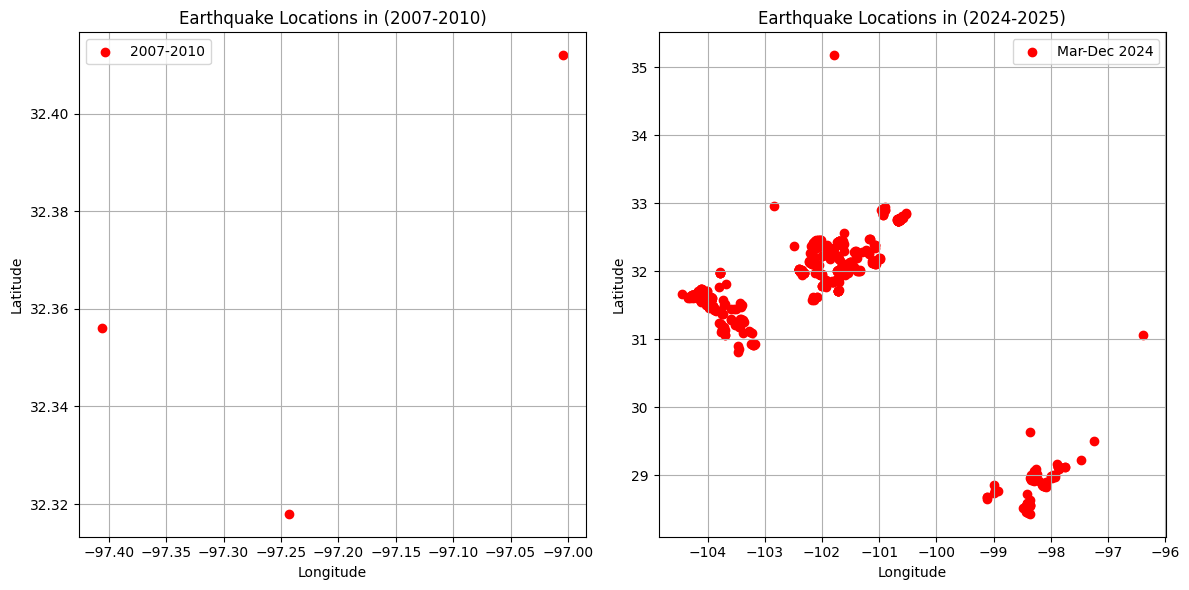

In [6]:
param1 = { "format": "geojson", "starttime": "2007-01-01","limit": 20000, "endtime": "2010-01-01", "minmagnitude": 1}
param2 = { "format": "geojson", "starttime": "2024-03-01","limit": 20000, "endtime": "2024-12-01", "minmagnitude": 1}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

response1 = requests.get(url, params=param1)
response2 = requests.get(url, params=param2)
data1 = json.loads(response1.text)
data2 = json.loads(response2.text)

quake_data1 = [
  Earthquake(
  Mag=feature['properties']['mag'],
  Place=feature['properties']['place'],
  Time=datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000),
  Lat=feature['geometry']['coordinates'][1],
  Long=feature['geometry']['coordinates'][0],
  Depth=feature['geometry']['coordinates'][2]
  )

  for feature in data1['features']
  if feature['geometry']['coordinates'][2] < 10 and "Texas" in feature['properties']['place']
]

quake_data2 = [
  Earthquake(
  Mag=feature['properties']['mag'],
  Place=feature['properties']['place'],
  Time= datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000),
  Lat=feature['geometry']['coordinates'][1],
  Long=feature['geometry']['coordinates'][0],
  Depth=feature['geometry']['coordinates'][2]
  )
  for feature in data2['features']
  if feature['geometry']['coordinates'][2] < 10 and "Texas" in feature['properties']['place']
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter([eq.Long for eq in quake_data1], [eq.Lat for eq in quake_data1], color='red', label='2007-2010')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Earthquake Locations in (2007-2010)')
ax1.grid(True)
ax1.legend()

ax2.scatter([eq.Long for eq in quake_data2], [eq.Lat for eq in quake_data2], color='Red', label='Mar-Dec 2024' )
ax2.set_xlabel('Longitude')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Earthquake Locations in (2024-2025)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
file_path = '/content/drive/MyDrive/Fracking.csv'
fracking_df = pd.read_csv(file_path)

@dataclass
class FrackingData:
  DisclosureId: str
  JobStartDate: datetime.datetime
  JobEndDate: datetime.datetime
  StateName: str
  CountyName: str
  Latitude: float
  Longitude: float
  TVD_Km: float
  TotalBaseWaterVolume: float


  def __init__(self, DisclosureId, JobStartDate, JobEndDate, StateName, CountyName, Latitude, Longitude, TVD_Km, TotalBaseWaterVolume):
    self.DisclosureId = DisclosureId
    self.StateName = StateName
    self.CountyName = CountyName
    self.Latitude = Latitude
    self.Longitude = Longitude
    self.TVD_Km = TVD_Km
    self.TotalBaseWaterVolume = TotalBaseWaterVolume

    # Coordinate transformation
    source_crs = 'epsg:4269'  # NAD83
    target_crs = 'epsg:4326'  # WGS84
    transformer = pyproj.Transformer.from_crs(source_crs, target_crs)
    self.Latitude_WGS84, self.Longitude_WGS84 = transformer.transform(self.Latitude, self.Longitude)

    # Convert dates to datetime objects
    self.JobStartDate = pd.to_datetime(JobStartDate)
    self.JobEndDate = pd.to_datetime(JobEndDate)

# Create a list of FrackingData objects
fracking_data_list = []
for index, row in fracking_df.iterrows():
    # Create a dictionary with the required keys and values from the row
    data_dict = {
        'DisclosureId': row['DisclosureId'],
        'JobStartDate': row['JobStartDate'],
        'JobEndDate': row['JobEndDate'],
        'StateName': row['StateName'],
        'CountyName': row['CountyName'],
        'Latitude': row['Latitude'],
        'Longitude': row['Longitude'],
        'TVD_Km': row['TVD(Km)'],
        'TotalBaseWaterVolume': row['TotalBaseWaterVolume']
    }
    # Create a FrackingData object using the dictionary and add it to the list
    fracking_data_list.append(FrackingData(**data_dict))

# Print job start and end dates
for fracking_data in fracking_data_list:
    print(f"JobStartDate: {fracking_data.JobStartDate}, JobEndDate: {fracking_data.JobEndDate}")

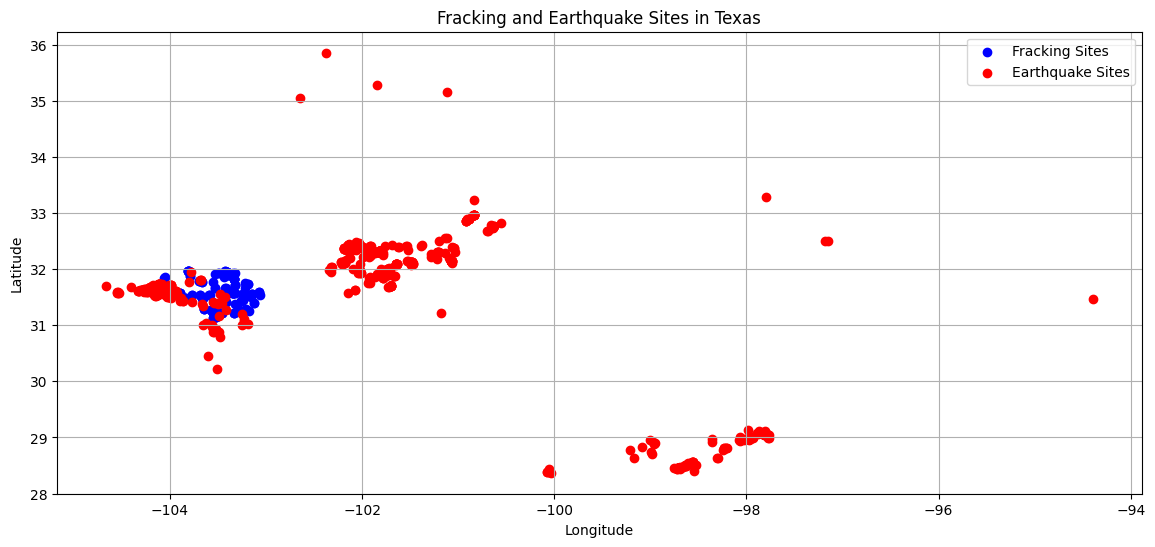

In [8]:
frac_lats = [site.Latitude_WGS84 for site in fracking_data_list]
frac_lons = [site.Longitude_WGS84 for site in fracking_data_list]


eq_lats = [eq.Lat for eq in earthquake_data]
eq_lons = [eq.Long for eq in earthquake_data]

plt.figure(figsize=(14, 6))


plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')

plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas')
plt.grid(True)
plt.legend()
plt.show()

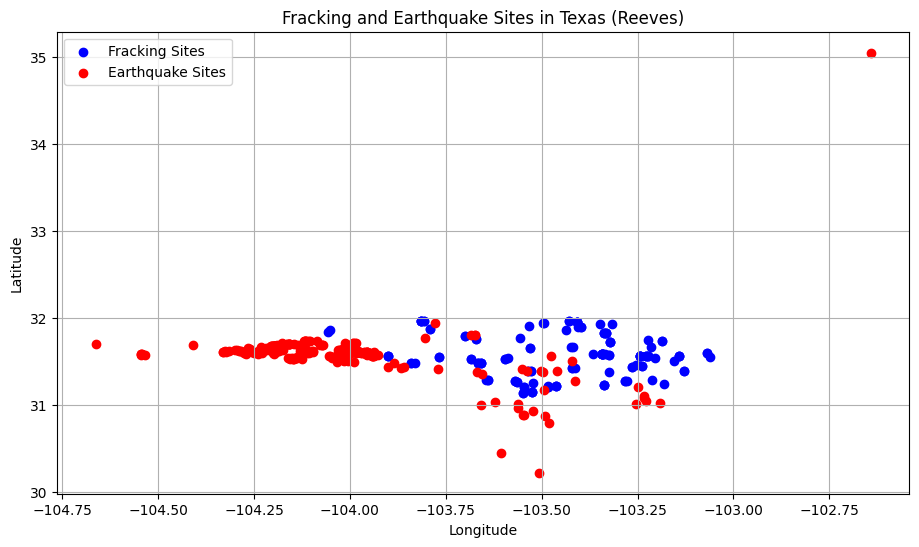

In [9]:
filtered_earthquake_data = [eq for eq in earthquake_data if eq.Long < -102.5]

frac_lats = [site.Latitude_WGS84 for site in fracking_data_list]
frac_lons = [site.Longitude_WGS84 for site in fracking_data_list]


eq_lats = [eq.Lat for eq in filtered_earthquake_data]
eq_lons = [eq.Long for eq in filtered_earthquake_data]

plt.figure(figsize=(11, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas (Reeves)')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
frac_site = fracking_data_list[49]
frac_site_surface_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, frac_site.TVD_Km)


graph = nx.Graph()
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

for eq in earthquake_data:
    eq_coords = (eq.Lat, eq.Long, 0)  # Earthquake surface coordinates (z=0)
    graph.add_node(f"Earthquake Site {eq.Place}", pos=eq_coords)

# Get node positions and invert z-coordinates
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])

# Get earthquake magnitudes and create color scale
eq_magnitudes = [eq.Mag for eq in earthquake_data if f"Earthquake Site {eq.Place}" in graph.nodes()]
color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))

# Create Plotly traces for nodes and edges
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in graph.nodes()],
    y=[pos[node][1] for node in graph.nodes()],
    z=[pos[node][2] for node in graph.nodes()],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_scale(i) if 'Earthquake Site' in node else 'blue' for i, node in enumerate(graph.nodes())],
        colorscale='Viridis',
        colorbar=dict(title='Magnitude')
    ),
    text=list(graph.nodes()),
    hoverinfo='text'
)

edge_trace = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

# Create the Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquake (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)",
                        xaxis=dict(  # X-axis background color
                            backgroundcolor="rgb(200, 200, 230)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        ),
                        yaxis=dict(  # Y-axis background color
                            backgroundcolor="rgb(230, 200, 230)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        ),
                        zaxis=dict(  # Z-axis background color
                            backgroundcolor="rgb(230, 230, 200)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        )
                        # aspectratio=dict(x=1, y=1, z=0.7),
                        # camera=dict(
                        #     eye=dict(x=1.4, y=1.4, z=1.25)
                        # )
                    ),
                    showlegend=True,
                )
                )


fig.show()

<ipython-input-10-2b506e8bf8d8>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))


In [11]:

# Assuming you have 'fracking_data_list' and 'earthquake_data' loaded

# Choose a specific fracking site (e.g., the 50th one, using index 49)
frac_site = fracking_data_list[49]
frac_site_surface_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, frac_site.TVD_Km)

# Create a graph
graph = nx.Graph()

# Add the fracking site (surface) as a node
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

# Add the fracking depth as a node
graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

# Connect the fracking site (surface) to the fracking depth
graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

# Add earthquake site nodes and connect if within radius
radius = 20  # 20 km radius
for eq in earthquake_data:
    eq_coords = (eq.Lat, eq.Long, 0)  # Earthquake surface coordinates (z=0)
    distance_to_frac_site = geodesic(frac_site_surface_coords[:2], eq_coords[:2]).kilometers  # Calculate horizontal distance

    if distance_to_frac_site <= radius:
        graph.add_node(f"Earthquake Site {eq.Place}", pos=eq_coords)
        graph.add_edge("Fracking Site (Surface)", f"Earthquake Site {eq.Place}")  # Connect if within radius

# Get node positions and invert z-coordinates
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])

# Get earthquake magnitudes and create color scale
eq_magnitudes = [eq.Mag for eq in earthquake_data if f"Earthquake Site {eq.Place}" in graph.nodes()]
color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))

# Create Plotly traces for nodes and edges
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in graph.nodes()],
    y=[pos[node][1] for node in graph.nodes()],
    z=[pos[node][2] for node in graph.nodes()],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_scale(i) if 'Earthquake Site' in node else 'blue' for i, node in enumerate(graph.nodes())],
        colorscale='Viridis',
        colorbar=dict(title='Magnitude')
    ),
    text=list(graph.nodes()),
    hoverinfo='text'
)

edge_trace = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

# Create the Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquakes within 20km Radius (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)"
                    ),
                    showlegend=True
                )
                )

fig.show()

<ipython-input-11-cfeb7fd290ff>:37: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



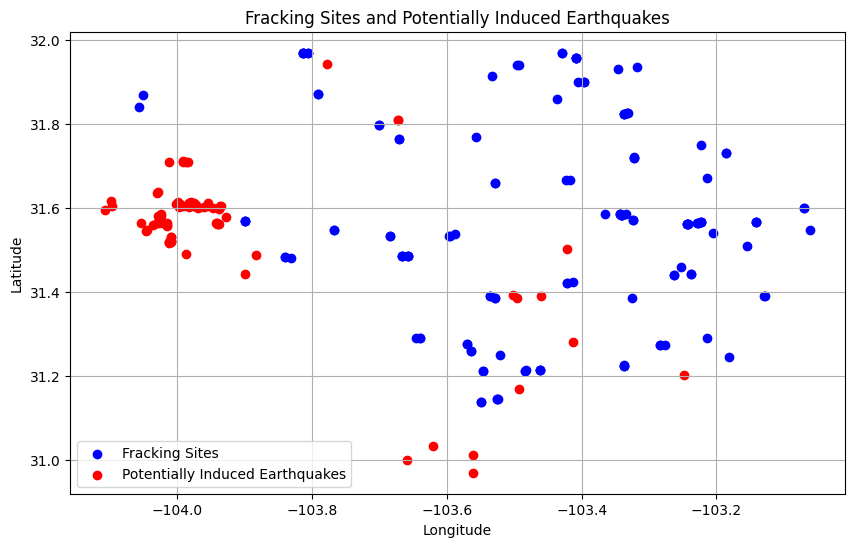

In [12]:
import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# ... (Your existing class definitions for FrackingData and Earthquake) ...

class EarthquakeAnalysis:
    def __init__(self, fracking_data, earthquake_data, radius_km=20, time_window_days=30):
        self.fracking_data = fracking_data
        self.earthquake_data = earthquake_data
        self.radius_km = radius_km
        self.time_window_days = time_window_days
        self.potentially_induced_earthquakes = []

    def find_potentially_induced_earthquakes(self):
        for eq in self.earthquake_data:
            for frac_site in self.fracking_data:
                distance = geodesic((frac_site.Latitude_WGS84, frac_site.Longitude_WGS84),
                                    (eq.Lat, eq.Long)).kilometers
                if distance <= self.radius_km:
                    if frac_site.JobStartDate - datetime.timedelta(days=1) <= eq.Time <= frac_site.JobEndDate + datetime.timedelta(days=self.time_window_days - 1):
                        self.potentially_induced_earthquakes.append(eq)
                        break  # Move to the next earthquake

    def visualize_earthquakes(self):
        plt.figure(figsize=(10, 6))

        plt.scatter([site.Longitude_WGS84 for site in self.fracking_data],
                    [site.Latitude_WGS84 for site in self.fracking_data],
                    color='blue', label='Fracking Sites')

        plt.scatter([eq.Long for eq in self.potentially_induced_earthquakes],
                    [eq.Lat for eq in self.potentially_induced_earthquakes],
                    color='red', label='Potentially Induced Earthquakes')

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Fracking Sites and Potentially Induced Earthquakes')
        plt.grid(True)
        plt.legend()
        plt.show()
analysis = EarthquakeAnalysis(fracking_data_list, earthquake_data)
analysis.find_potentially_induced_earthquakes()
analysis.visualize_earthquakes()

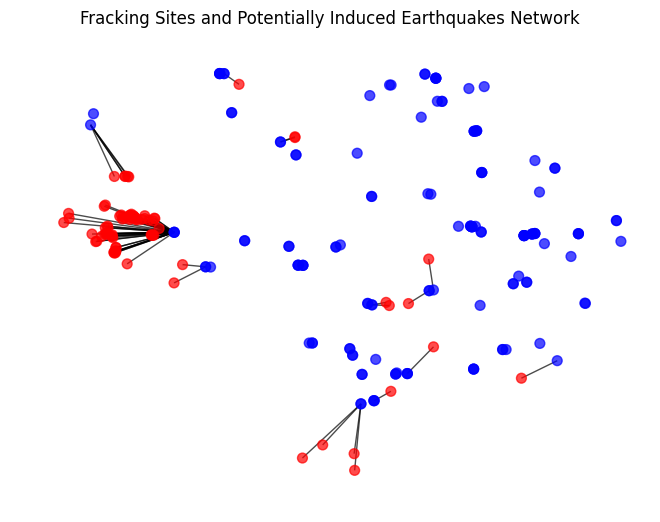

In [13]:
import datetime
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import networkx as nx

# ... (Your existing class definitions for FrackingData and Earthquake) ...

class EarthquakeAnalysis:
    # ... (Previous code from the EarthquakeAnalysis class) ...

    def __init__(self, fracking_data, earthquake_data, radius_km=20, time_window_days=30):
        self.fracking_data = fracking_data
        self.earthquake_data = earthquake_data
        self.radius_km = radius_km
        self.time_window_days = time_window_days
        self.potentially_induced_earthquakes = []

    def find_potentially_induced_earthquakes(self):
        for eq in self.earthquake_data:
            for frac_site in self.fracking_data:
                distance = geodesic((frac_site.Latitude_WGS84, frac_site.Longitude_WGS84),
                                    (eq.Lat, eq.Long)).kilometers
                if distance <= self.radius_km:
                    if frac_site.JobStartDate - datetime.timedelta(days=1) <= eq.Time <= frac_site.JobEndDate + datetime.timedelta(days=self.time_window_days - 1):
                        self.potentially_induced_earthquakes.append(eq)
                        break  # Move to the next earthquake


    def create_network_graph(self):
        """Creates a NetworkX graph representing fracking sites and potentially induced earthquakes."""
        self.graph = nx.Graph()  # Initialize an empty graph

        # Add fracking sites as nodes
        for frac_site in self.fracking_data:
            self.graph.add_node(
                f"Fracking Site {frac_site.DisclosureId}",
                pos=(frac_site.Longitude_WGS84, frac_site.Latitude_WGS84),  # Store coordinates as node attribute
                site_type="fracking",  # Add a type attribute
            )

        # Add potentially induced earthquakes as nodes and connect to fracking sites
        for eq in self.potentially_induced_earthquakes:
            self.graph.add_node(
                f"Earthquake {eq.Time}",  # Use time for unique earthquake ID
                pos=(eq.Long, eq.Lat),
                site_type="earthquake",
                magnitude=eq.Mag,  # Store magnitude as node attribute
            )

            # Find nearest fracking site and create edge
            nearest_frac_site = min(
                self.fracking_data,
                key=lambda site: geodesic((site.Latitude_WGS84, site.Longitude_WGS84), (eq.Lat, eq.Long)).kilometers,
            )
            distance = geodesic((nearest_frac_site.Latitude_WGS84, nearest_frac_site.Longitude_WGS84), (eq.Lat, eq.Long)).kilometers
            self.graph.add_edge(
                f"Fracking Site {nearest_frac_site.DisclosureId}",
                f"Earthquake {eq.Time}",
                weight=distance,  # Store distance as edge attribute
            )

    def visualize_network_graph(self):
        """Visualizes the NetworkX graph."""
        pos = nx.get_node_attributes(self.graph, "pos")
        node_colors = ["blue" if self.graph.nodes[node]["site_type"] == "fracking" else "red" for node in self.graph.nodes()]

        nx.draw(self.graph, pos, with_labels=False, node_color=node_colors, node_size=50, alpha=0.7)
        plt.title("Fracking Sites and Potentially Induced Earthquakes Network")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()

# Example usage:
analysis = EarthquakeAnalysis(fracking_data_list, earthquake_data)
analysis.find_potentially_induced_earthquakes()
analysis.create_network_graph()
analysis.visualize_network_graph()

Aggregated Data:
   earthquake_count  job_duration  TotalBaseWaterVolume    TVD_Km
0                 4            16            29845158.0  3.316224
1                 4            16            30241764.0  3.321406
2                 4            16            29785140.0  3.311652
3                 4            12            31173450.0  3.316529
4                 4            12            30115512.0  3.315310


Output()

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0       0.721  0.080   0.573    0.872      0.002    0.001    1730.0   
beta_job   -0.253  0.039  -0.326   -0.181      0.001    0.001    3052.0   
beta_tvd   -2.645  0.110  -2.859   -2.447      0.003    0.002    1733.0   
beta_water -0.663  0.052  -0.756   -0.565      0.001    0.001    3122.0   

            ess_tail  r_hat  
beta0         2296.0    1.0  
beta_job      2383.0    1.0  
beta_tvd      2013.0    1.0  
beta_water    2478.0    1.0  


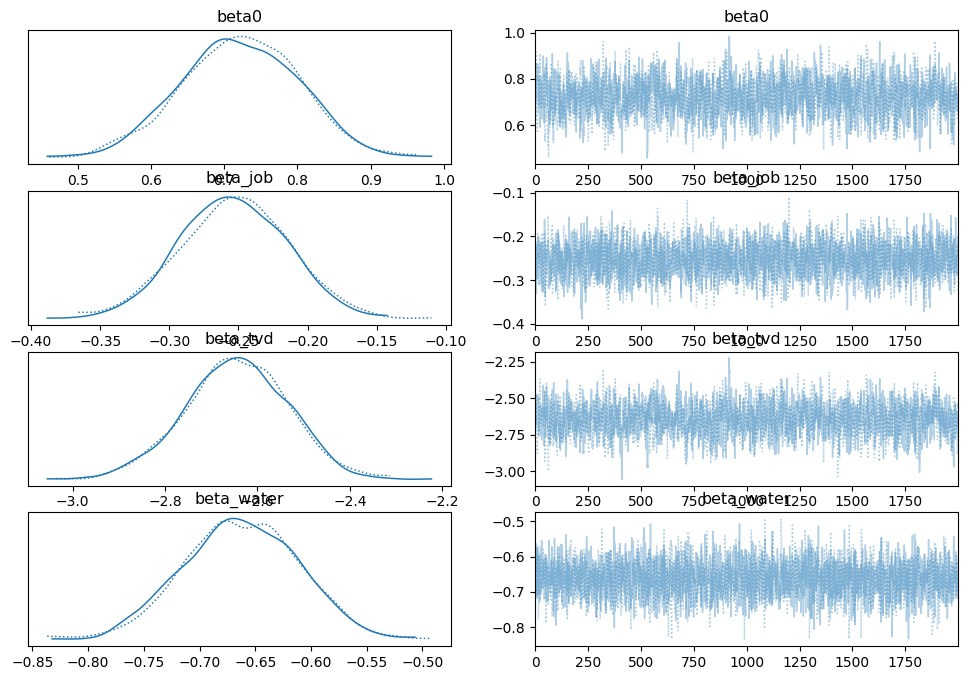

In [24]:
import numpy as np
import pandas as pd
import pymc as pm
from geopy.distance import geodesic
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# -------------------------------
# STEP 1: Aggregate Earthquake Counts per Fracking Site
# -------------------------------
radius_km = 20  # Radius in km to consider an earthquake as "near" a fracking site

quake_counts = []      # number of earthquakes within radius per site
job_durations = []     # duration of fracking jobs (in days)
total_base_water = []  # Total base water volume for each site
tvd_list = []          # TVD (Total Vertical Depth) for each site

# Assuming fracking_data_list and earthquake_data are already populated
for site in fracking_data_list:
    site_coords = (site.Latitude_WGS84, site.Longitude_WGS84)

    # Count earthquakes within the specified radius (ignoring depth here)
    count = sum(geodesic(site_coords, (eq.Lat, eq.Long)).kilometers <= radius_km
                for eq in earthquake_data)
    quake_counts.append(count)

    # Calculate job duration in days (ensure dates are datetime objects)
    duration = (site.JobEndDate - site.JobStartDate).days
    job_durations.append(duration)

    total_base_water.append(site.TotalBaseWaterVolume)
    tvd_list.append(site.TVD_Km)

# Create a DataFrame for modeling
model_df = pd.DataFrame({
    'earthquake_count': quake_counts,
    'job_duration': job_durations,
    'TotalBaseWaterVolume': total_base_water,
    'TVD_Km': tvd_list
})

print("Aggregated Data:")
print(model_df.head())

# -------------------------------
# STEP 2: Scale the Predictors
# -------------------------------
scaler = StandardScaler()
predictors = model_df[['job_duration', 'TotalBaseWaterVolume', 'TVD_Km']]
scaled_predictors = scaler.fit_transform(predictors)

model_df['job_duration_scaled'] = scaled_predictors[:, 0]
model_df['TotalBaseWaterVolume_scaled'] = scaled_predictors[:, 1]
model_df['TVD_Km_scaled'] = scaled_predictors[:, 2]

# -------------------------------
# STEP 3: Build and Sample the Bayesian Poisson Regression Model
# -------------------------------
with pm.Model() as model:
    # Priors for regression coefficients
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta_job = pm.Normal('beta_job', mu=0, sigma=10)
    beta_water = pm.Normal('beta_water', mu=0, sigma=10)
    beta_tvd = pm.Normal('beta_tvd', mu=0, sigma=10)

    # Linear predictor using scaled predictors
    mu = (beta0 +
          beta_job * model_df['job_duration_scaled'] +
          beta_water * model_df['TotalBaseWaterVolume_scaled'] +
          beta_tvd * model_df['TVD_Km_scaled'])

    # Expected count (ensure it's positive)
    lambda_ = pm.math.exp(mu)

    # Poisson likelihood
    quake_obs = pm.Poisson('quake_obs', mu=lambda_, observed=model_df['earthquake_count'])

    # Sample from the posterior distribution
    trace = pm.sample(2000, tune=1000, cores=2, random_seed=42)

# -------------------------------
# STEP 4: Review and Plot the Results
# -------------------------------
print(pm.summary(trace))

pm.plot_trace(trace)
plt.show()
